In [107]:
import pandas as pd
import numpy as np

from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown


In [108]:
replacement_dict = {
    **{f"{i}. Kat": str(i) for i in range(1, 31)},
    "Bahçe Katı": "0",
    "Düz Giriş": "0",
    "Yüksek Giriş": "0"
}
replacement_dict

{'1. Kat': '1',
 '2. Kat': '2',
 '3. Kat': '3',
 '4. Kat': '4',
 '5. Kat': '5',
 '6. Kat': '6',
 '7. Kat': '7',
 '8. Kat': '8',
 '9. Kat': '9',
 '10. Kat': '10',
 '11. Kat': '11',
 '12. Kat': '12',
 '13. Kat': '13',
 '14. Kat': '14',
 '15. Kat': '15',
 '16. Kat': '16',
 '17. Kat': '17',
 '18. Kat': '18',
 '19. Kat': '19',
 '20. Kat': '20',
 '21. Kat': '21',
 '22. Kat': '22',
 '23. Kat': '23',
 '24. Kat': '24',
 '25. Kat': '25',
 '26. Kat': '26',
 '27. Kat': '27',
 '28. Kat': '28',
 '29. Kat': '29',
 '30. Kat': '30',
 'Bahçe Katı': '0',
 'Düz Giriş': '0',
 'Yüksek Giriş': '0'}

In [109]:
df = pd.read_csv("C:/Users/MERT/Desktop/ikcu_dersler/Yazılım Yüksek Lisans/2. Dönem/Python Programlama/Vize-Final/Final/Real Estate in ISTANBUL (Emlakjet).csv", encoding='utf-8')
df.head()

,İlan_Numarası,İlan_Güncelleme_Tarihi,Kategorisi,Brüt_Metrekare,Binanın_Yaşı,Binanın_Kat_Sayısı,Kullanım_Durumu,Yatırıma_Uygunluk,Eşya_Durumu,Banyo_Sayısı,...,Site_İçerisinde,Takas,Fiyat_Durumu,Fiyatı,İl,İlçe,Mahalle,yaka,Yaşam_endeksi,Nüfus
0,2003,02 Şubat 2022,Satılık,190,5-10,20,Kiracı Oturuyor,Bilinmiyor,Yok,2,...,Hayır,Var,Genel Fiyat,18000000,İstanbul,Beşiktaş,Nisbetiye Mahallesi,Avrupa Yakası,0.911,178.938
1,166,14 Ocak 2022,Satılık,300,21 Ve Üzeri,2,Kiracı Oturuyor,Bilinmiyor,Yok,3,...,Hayır,Var,Genel Fiyat,8500000,İstanbul,Beşiktaş,Akat Mahallesi,Avrupa Yakası,0.911,178.938
2,167,14 Ocak 2022,Satılık,350,21 Ve Üzeri,3,Mülk Sahibi Oturuyor,Bilinmiyor,Yok,2,...,Hayır,Var,Genel Fiyat,16500000,İstanbul,Beşiktaş,Levent Mahallesi,Avrupa Yakası,0.911,178.938
3,115,06 Ocak 2022,Satılık,450,5-10,4,Kiracı Oturuyor,Bilinmiyor,Yok,3,...,Hayır,Var,Genel Fiyat,22000000,İstanbul,Beşiktaş,Levazım Mahallesi,Avrupa Yakası,0.911,178.938
4,2879,08 Şubat 2022,Satılık,160,21 Ve Üzeri,2,Mülk Sahibi Oturuyor,Bilinmiyor,Yok,1,...,Hayır,Var,Genel Fiyat,4250000,İstanbul,Beşiktaş,Nisbetiye Mahallesi,Avrupa Yakası,0.911,178.938


In [110]:
def wrangle(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath, encoding='utf-8')

    df.drop(columns=[
        "İlan_Numarası", "İlan_Güncelleme_Tarihi", "Kategorisi", "İlan_Oluşturma_Tarihi", "Türü",
        "Fiyat_Durumu", "İl", "Brüt_Metrekare", "Kullanım_Durumu", "Yatırıma_Uygunluk",
        "Krediye_Uygunluk", "Takas", "Eşya_Durumu", "Site_İçerisinde", "Yaşam_endeksi", "Nüfus"
    ], inplace=True)

    area_low, area_high = df["Net_Metrekare"].quantile([0.05, 0.95])
    df = df[df["Net_Metrekare"].between(area_low, area_high)]

    price_low, price_high = df["Fiyatı"].quantile([0.05, 0.95])
    df = df[df["Fiyatı"].between(price_low, price_high)]

    df["Fiyatı"] = df["Fiyatı"] / 1_000_000

    df["Banyo_Sayısı"] = df["Banyo_Sayısı"].str.strip().replace({
        "Var": "1", "Yok": "0", "6+": "6", "28 M2": "2"
    })
    df = df[df["Banyo_Sayısı"] != "Genel Fiyat"]
    df["Banyo_Sayısı"] = df["Banyo_Sayısı"].astype(int)

    df["Binanın_Yaşı"] = df["Binanın_Yaşı"].str.strip().replace({
        "21 Ve Üzeri": "21", "0 (Yeni)": "0",
        "16-20": "20", "11-15": "15", "5-10": "10"
    }).astype(int)

    df["Bulunduğu_Kat"] = df["Bulunduğu_Kat"].str.strip().replace(replacement_dict)
    df["Bulunduğu_Kat"] = df["Bulunduğu_Kat"].replace({
        "30-40. Kat": "40", "10-20. Kat": "20", "Kot 1 (-1). Kat": "-1",
        "Kot 2 (-2). Kat": "-2", "Kot 3 (-3). Kat": "-3", "Villa Tipi": "0",
        "Müstakil": "0", "Tam Bodrum": "0"
    })

    df.loc[df["Bulunduğu_Kat"].isin(["Çatı Katı", "Çatı Dubleks"]), "Bulunduğu_Kat"] = df["Binanın_Kat_Sayısı"]
    df["Bulunduğu_Kat"] = df["Bulunduğu_Kat"].astype(int)

    df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
    df["Oda_Sayısı"] = df["Oda_Sayısı"].replace({
        "Stüdyo": "1+0", "1 Oda": "1+0", "8+ Oda": "1+0"
    })

    df[["oda", "salon"]] = df["Oda_Sayısı"].str.split("+", expand=True).astype(float)
    df["Oda_Sayısı"] = df["oda"] + df["salon"]
    df.drop(columns=["oda", "salon"], inplace=True)

    return df

csv_path = "data/real_estate_istanbul.csv"
df = wrangle(csv_path)

In [111]:
df.head()

,Binanın_Yaşı,Binanın_Kat_Sayısı,Banyo_Sayısı,Net_Metrekare,Oda_Sayısı,Bulunduğu_Kat,Isıtma_Tipi,Fiyatı,İlçe,Mahalle,yaka
1,21,2,3,270,6.0,0,Doğalgaz,8.500,Beşiktaş,Akat Mahallesi,Avrupa Yakası
4,21,2,1,140,4.0,1,Doğalgaz,4.250,Beşiktaş,Nisbetiye Mahallesi,Avrupa Yakası
5,21,4,1,55,3.0,0,Doğalgaz,0.875,Beşiktaş,Arnavutköy Mahallesi,Avrupa Yakası
7,21,7,1,85,3.0,0,Doğalgaz,1.250,Beşiktaş,Etiler Mahallesi,Avrupa Yakası
8,21,9,1,130,4.0,8,Doğalgaz,4.950,Beşiktaş,Nisbetiye Mahallesi,Avrupa Yakası


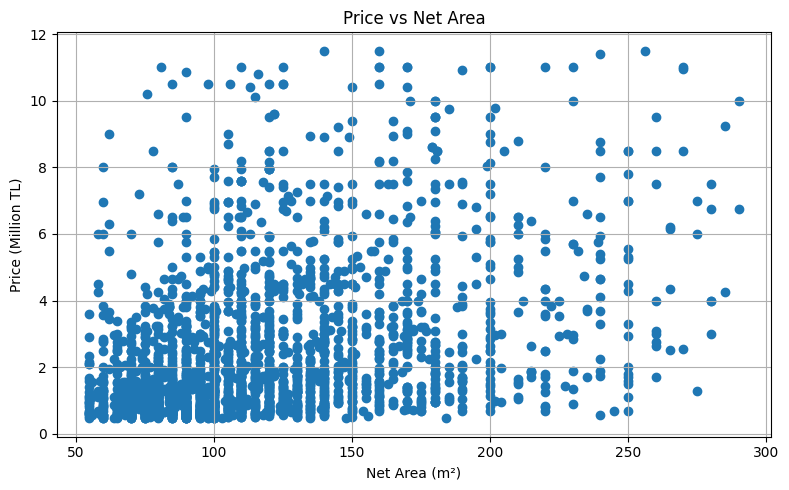

In [112]:
plt.figure(figsize=(8, 5))
plt.scatter(df["Net_Metrekare"], df["Fiyatı"])
plt.xlabel("Net Area (m²)")
plt.ylabel("Price (Million TL)")
plt.title("Price vs Net Area")
plt.grid(True)
plt.tight_layout()
plt.show()

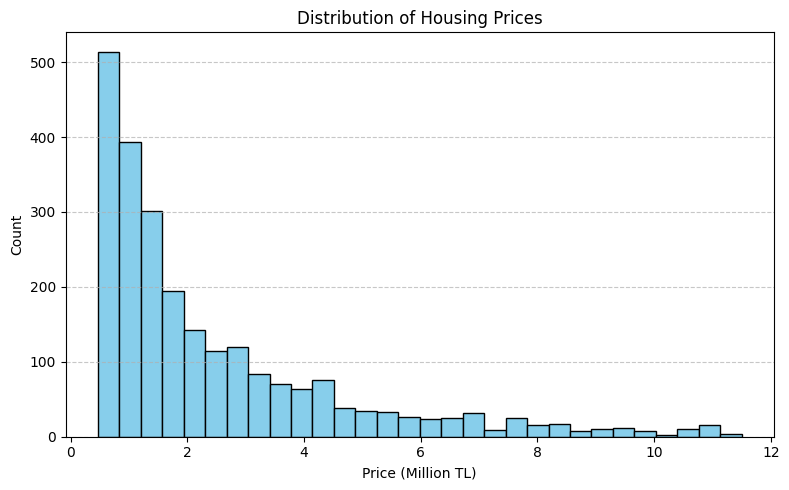

In [113]:
plt.figure(figsize=(8, 5))
plt.hist(df["Fiyatı"], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Price (Million TL)")
plt.ylabel("Count")
plt.title("Distribution of Housing Prices")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


İlçe
Şişli       5.766667
Kadıköy     4.895845
Sarıyer     4.614263
Beşiktaş    4.566080
Bakırköy    3.658057
Name: Fiyatı, dtype: float64


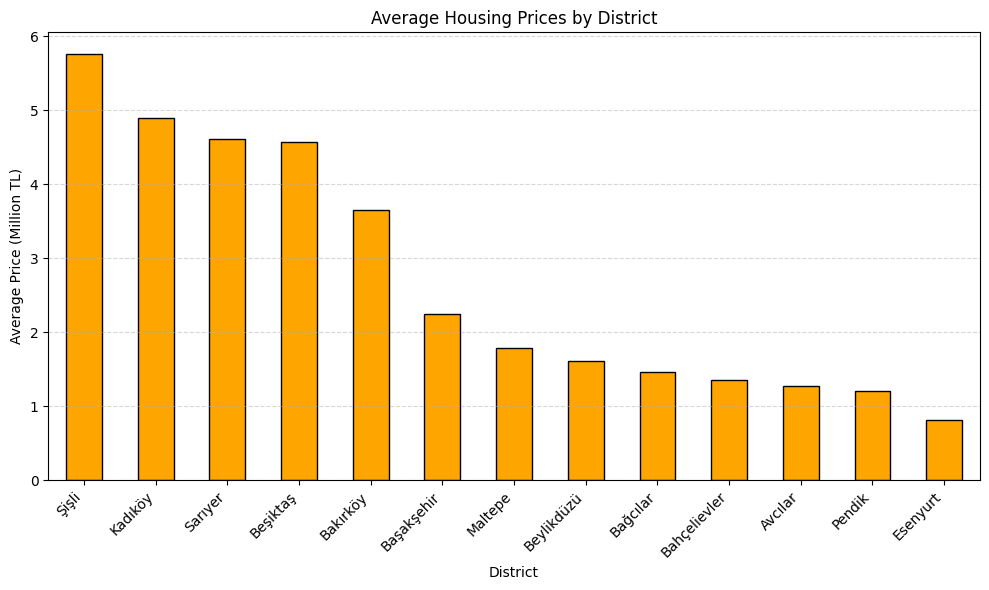

In [114]:
avg_price_by_district = df.groupby("İlçe")["Fiyatı"].mean().sort_values(ascending=False)

print(avg_price_by_district.head())

plt.figure(figsize=(10, 6))
avg_price_by_district.plot(kind="bar", color="orange", edgecolor="black")
plt.xlabel("District")
plt.ylabel("Average Price (Million TL)")
plt.title("Average Housing Prices by District")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [115]:
y = df["Fiyatı"]
X = df.drop(columns=["Fiyatı"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 2300
Test samples: 122


In [116]:

baseline_prediction = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, baseline_prediction)

print(f"Mean Housing Price: {y_train.mean():.2f} Million TL")
print(f"Baseline MAE: {baseline_mae:.4f}")

Mean Housing Price: 2.46 Million TL
Baseline MAE: 1.6597


In [117]:
y_train_log = np.log1p(y_train)

model = make_pipeline(
    OneHotEncoder(use_cat_names=True, handle_unknown="ignore"),
    GradientBoostingRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    )
)
model.fit(X_train, y_train_log)


y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 0.7516515452441833


In [118]:
rf_model = model.named_steps["gradientboostingregressor"]
features = model.named_steps["onehotencoder"].get_feature_names_out()
feat_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values()

print("\nTop 10 Most Important Features:")
print(feat_importance.tail(10))

print("\nTop 10 Least Important Features:")
print(feat_importance.head(10))



Top 10 Most Important Features:
İlçe_Esenyurt         0.026048
Binanın_Yaşı          0.032261
Bulunduğu_Kat         0.035063
İlçe_Bakırköy         0.057362
Binanın_Kat_Sayısı    0.067313
İlçe_Sarıyer          0.068230
İlçe_Beşiktaş         0.068566
Net_Metrekare         0.142545
Banyo_Sayısı          0.159307
İlçe_Kadıköy          0.163895
dtype: float64

Top 10 Least Important Features:
Mahalle_Ahmet Yesevi Mahallesi     0.0
Mahalle_İncirtepe Mahallesi        0.0
Mahalle_Adnan Kahveci Mahallesi    0.0
Mahalle_Caddebostan Mahallesi      0.0
Mahalle_Şeyhli Mahallesi           0.0
Mahalle_Güzelyalı Mahallesi        0.0
Mahalle_İnönü Mahallesi            0.0
Mahalle_Mehterçeşme Mahallesi      0.0
Mahalle_Yeşilkent Mahallesi        0.0
Mahalle_Yenişehir Mahallesi        0.0
dtype: float64


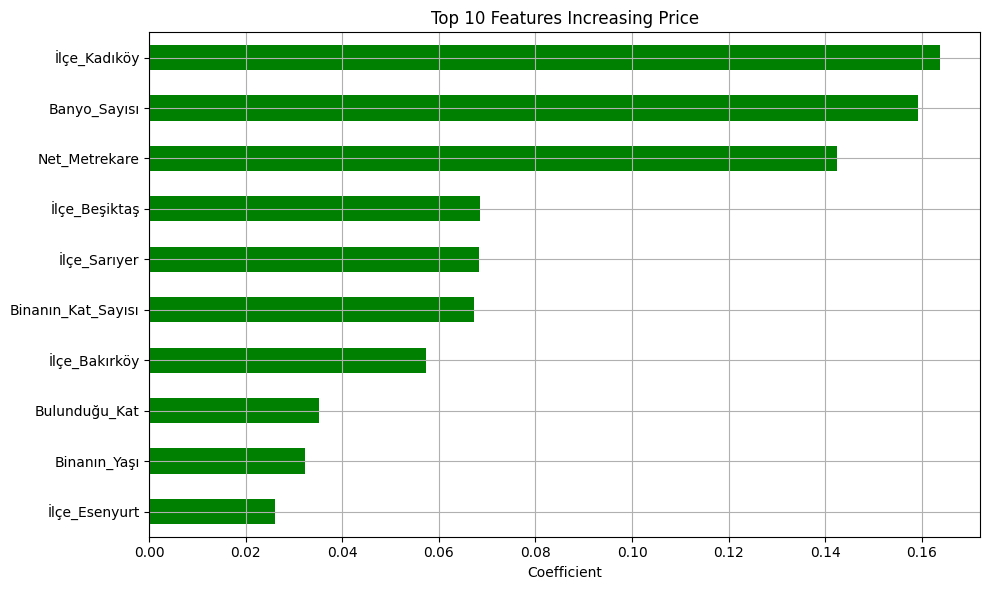

In [119]:
plt.figure(figsize=(10, 6))
feat_importance.tail(10).plot(kind='barh', color='green')
plt.title("Top 10 Features Increasing Price")
plt.xlabel("Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()


In [120]:
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index)

print("Sample Predictions:")
print(y_test_pred.head())

test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"\nTest MAE: {test_mae:.4f} Million TL")


Sample Predictions:
798     0.828411
1549    1.359459
1126    0.631655
415     1.171404
796     0.827234
dtype: float64

Test MAE: 1.2915 Million TL


In [121]:
MAE_test = mean_absolute_error(y_test, y_test_pred)
print(f"Baseline MAE (mean predictor): {baseline_mae:.4f}")
print(f"Test MAE (ridge model):        {MAE_test:.4f}")


Baseline MAE (mean predictor): 1.6597
Test MAE (ridge model):        1.2915


In [122]:
results = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_test_pred
})

results.head(10)

,Actual Price,Predicted Price
798,0.830,0.828411
1549,3.650,1.359459
1126,0.545,0.631655
415,2.000,1.171404
796,0.620,0.827234
152,4.550,1.794612
353,0.700,0.949573
2832,3.500,1.908785
1205,4.150,0.995276
778,1.250,1.083231


In [123]:
X_train.columns

Index(['Binanın_Yaşı', 'Binanın_Kat_Sayısı', 'Banyo_Sayısı', 'Net_Metrekare',
       'Oda_Sayısı', 'Bulunduğu_Kat', 'Isıtma_Tipi', 'İlçe', 'Mahalle',
       'yaka'],
      dtype='object')

In [124]:
TRAIN_COLUMNS = X_train.columns.tolist()

def make_prediction(building_age, total_floors, bathroom_count, net_area, room_count, floor_number, type_heating, district, neighborhood, side):
    data = {
        "Binanın_Yaşı":        [building_age],
        "Binanın_Kat_Sayısı":  [total_floors],
        "Banyo_Sayısı":        [bathroom_count],
        "Net_Metrekare":       [net_area],
        "Oda_Sayısı":          [room_count],
        "Bulunduğu_Kat":       [floor_number],
        "Isıtma_Tipi":         [type_heating],
        "İlçe":                [district],
        "Mahalle":             [neighborhood],
        "yaka":                [side]
    }

    ordered_columns = ["Binanın_Yaşı", "Binanın_Kat_Sayısı", "Banyo_Sayısı", "Net_Metrekare",
                       "Oda_Sayısı", "Bulunduğu_Kat", "Isıtma_Tipi", "İlçe", "Mahalle", "yaka"]
    data = {col: data[col] for col in ordered_columns}
    input_df = pd.DataFrame(data)

    pred_log = model.predict(input_df)[0]
    pred = np.expm1(pred_log).round(2)

    return f"Estimated housing price: {pred} million TL"

In [125]:
building_age = 10
total_floors = 3
floor_number = 3
net_area = 100
room_count = 3
bathroom_count = 2
district = "Kadıköy"
neighborhood = "Erenköy Mahallesi"
side = "Anadolu Yakası"
type_heating = "Klimalı"

make_prediction(building_age, total_floors, bathroom_count, net_area, room_count,
                floor_number, type_heating, district, neighborhood, side)


'Estimated housing price: 4.19 million TL'

In [126]:
interact(
    make_prediction,
    building_age = IntSlider(
        min   = int(X_train["Binanın_Yaşı"].min()),
        max   = int(X_train["Binanın_Yaşı"].max()),
        value = int(X_train["Binanın_Yaşı"].mean()),
        description = "Building Age"
    ),

    total_floors = IntSlider(
        min   = int(X_train["Binanın_Kat_Sayısı"].min()),
        max   = int(X_train["Binanın_Kat_Sayısı"].max()),
        value = int(X_train["Binanın_Kat_Sayısı"].mean()),
        description = "Total Floors"
    ),

    floor_number = IntSlider(
        min   = int(X_train["Bulunduğu_Kat"].min()),
        max   = int(X_train["Binanın_Kat_Sayısı"].max()),
        value = int(X_train["Bulunduğu_Kat"].mean()),
        description = "Floor Number"
    ),

    bathroom_count = IntSlider(
        min   = int(X_train["Banyo_Sayısı"].min()),
        max   = int(X_train["Banyo_Sayısı"].max()),
        value = int(X_train["Banyo_Sayısı"].mean()),
        description = "Bathrooms"
    ),

    net_area = FloatSlider(
        min   = X_train["Net_Metrekare"].min(),
        max   = X_train["Net_Metrekare"].max(),
        step  = 0.5,
        value = X_train["Net_Metrekare"].mean(),
        description = "Net Area (m²)"
    ),

    room_count = IntSlider(
        min   = int(X_train["Oda_Sayısı"].min()),
        max   = int(X_train["Oda_Sayısı"].max()),
        value = int(X_train["Oda_Sayısı"].mean()),
        description = "Rooms"
    ),

    # ---- kategorik dropdown'lar ----
    district = Dropdown(
        options = sorted(X_train["İlçe"].unique()),
        description = "District"
    ),

    type_heating = Dropdown(
        options = sorted(X_train["Isıtma_Tipi"].unique()),
        description = "Heating"
    ),

    neighborhood = Dropdown(
        options = sorted(X_train["Mahalle"].unique()),
        description = "Neighborhood"
    ),

    side = Dropdown(
        options = sorted(X_train["yaka"].unique()),
        description = "Side"
    )
);


interactive(children=(IntSlider(value=8, description='Building Age', max=21), IntSlider(value=8, description='…